# Chaos during a stampede

Based on the paper: https://www.sciencedirect.com/science/article/pii/S1569190X20300861?casa_token=eoCj844--UoAAAAA%3AW5IEQVZQbP5ILasesMnahd3iIgfHNXfAWnaI7RsboLHrfqNA-UNxb_pyNF5FIyDN0hoKbjdC-EA 

### To do:
Implement everything

### Ideas:
Implement people as class so that we can define their state and position as parts of that class.

Use code example below, set all bordercells to 500 (= wall)
Use different values for different states of people.
Make custom update rules.

### Steps:
1. Populate board with random amount of people in random positions
2. In each time step, calculate the static floor field Sij, the dynamic floor field Dij and the event floor field Fij with help of the formulas.
3. For each pedestrian, determine his/her state and make a decision regarding movement behavior. If the pedestrian is in
state Ue,Un or Ae, calculate the transition probability according to Eqs. (15)–(17), respectively. If the pedestrian is in state An, he/
she chooses one of the strategies S1, S2 or S3 to evacuate. If the pedestrian is in state C, calculate the probability of him/her
getting up again.
4. Each pedestrian moves to his/her target cell. If the pedestrian chooses a target cell that is occupied by a fallen pedestrian, he/she will be tripped and become a new fallen pedestrian.
5. If the chaos duration is over, uninjured pedestrians regard fallen pedestrians as obstacles and conduct a normal evacuation. There will be no more new fallen pedestrians.
6. When multiple pedestrians choose to move to the same target, one pedestrian is randomly selected with equal probability to move to the target cell, and other pedestrians remain in their original cells.
7. Determine whether the evacuation is over. If there are still uninjured pedestrians in the room, return to step 2 and repeat the simulation process until all the uninjured pedestrians evacuate from the room.

### Variables:

S = static floor: describes pedestrian behavior of finding the shortest path to the exit during the evacuation process.
D = dynamic floor: represents the interactions among pedestrians in the evacuation process.
F = event floor: reflects thhat some pedestrians intend to escape from the stampede location when they are affected by the stampede.
A = risk floor field: depicts that pedestrian movement direction affects the risk of being tripped.

### evac strategies:
S1 = Tries to stay away from the stampede location (Eq 1)
S2 = Follows movement of neighbours 
S3 = keeps moving in same direction until wall is reached, then follows it clockwise or anti clockwise.
     when they stay in the same cell for more then 5 time steps, they change the desired direction randomly.


In [2]:
# imports

import numpy as np
import random
import matplotlib.pyplot as plt

In [78]:
# functions

def init_board(board_size,num_people,exit_locs,sight_radius,state_dic):
    """ populate board with size r x r with x people
        decide where exits are with e list of locations of exits
        set remaining walls to 500 
        Inputs:
            board_size: The size of the board
            num_people: The number of people on the board
            exit_locs: The locations of the exits given as an array(y,x)
            sight_radius: How far the people should be able to see
            state_dic: The dictionary of the states and their according number
        Outputs:
            The board filled with numeric values. Where each state is represented by a certain number
            The list of people on the board, this is the list that we can iterate over every time.
        """

    # create board with all walls being 500
    board = np.ones((board_size,board_size)) * 500
    board[1:-1,1:-1] = 0

    # add the exit locations
    board[exit_locs] = 1

    # calculate all possible locations
    locations = []

    for x in range(1,board_size-1):
        for y in range(1,board_size-1):
            locations.append([x,y])

    if len(locations) >= num_people:
        uniq_locations = random.sample(locations,num_people)
    else:
        raise ValueError('num_people can not be greater than the number of free spaces on the board')

    # add the people to the board
    person_list = []

    exits = [[exit_locs[0][i], exit_locs[1][i]] for i in range(len(exit_locs[0]))]

    for i,location in enumerate(uniq_locations):
        # set standard state to 'Un' if exit in range set to 'Ue'
        pstate = 'Un'
        for exit_loc in exits:
            if np.sqrt((exit_loc[0]-location[0])**2+(exit_loc[1]-location[1])**2) <= sight_radius:
                pstate = 'Ue'
        
        person_list.append(Pedestrian(location,pstate))

        board[location[0], location[1]] = state_dic[pstate]

    return board, person_list

def get_locations(person_list):
    return np.array([person.location for person in person_list])

def get_directions(board_size,person_list):
    directionmap = np.zeros((board_size,board_size,2))
    for person in person_list:
        directionmap[person.location[0],person.location[1],:] = person.direction

    return directionmap

def init_S(board_size, S_wall, S_exit, obstacle_locs, exit_locs, mu):
    """Creates the initial static floor field S.
    The static floor field describes the path on the grid which is the shortest way to the exit.
    All walls are assumed to be on the outside of the grid.
    Inputs:
      board_size: Length of the square board
      S_wall: Value of the static field for a wall or obstacle
      S_exit: Value of the static field for the exit
      obstacle_locs: Locations of the obstacles on the grid
      exit_locs: Locations of the exit
      mu: Ratio of distance when travelling to a neighbouring diagonal cell over travelling to a neighbouring cell on a side
    """
    S = np.ones((board_size, board_size)) * np.inf # Initialise array full of +infinity since filling up S is based on selecting minimum values
    side_neighbour_mask = np.zeros((3, 3), dtype = bool)
    side_neighbour_mask[0, 1] = side_neighbour_mask[1, 0] = side_neighbour_mask[1, -1] = side_neighbour_mask[-1, 1] = True

    diag_neighbour_mask = np.zeros((3,3), dtype = bool)
    diag_neighbour_mask[0, 0] = diag_neighbour_mask[0, -1] = diag_neighbour_mask[-1, 0] = diag_neighbour_mask[-1, -1] = True

    S[exit_locs] = S_exit

    curr_cells = [[exit_locs[0][i], exit_locs[1][i]] for i in range(len(exit_locs[0]))]
    next_cells = []
    done_cells = []


    # The exit cells are the only cells on the border to evaluate and require a special treatment (don't select any cells outside of the existing grid)
    for y, x in curr_cells:
        for i in np.arange(np.maximum(1, y-1), np.minimum(board_size, y+2)):
            for j in np.arange(np.maximum(1, x-1), np.minimum(board_size, x+2)):
                if (i, j) != (y, x):
                    if ((y-i)+(x-j))%2 == 0: # diagonal neighbour
                        S[i,j] = np.minimum(S[y, x] + mu, S[i, j])
                    else: # side neighbour
                        S[i,j] = np.minimum(S[y, x] + 1, S[i, j])

                    next_cells += [[i, j]]

                    S[:, 0] = S[:, -1] = S_wall
                    S[0, :] = S[-1, :] = S_wall
                    if obstacle_locs: # => If the list of obstacles isn't empty
                        S[obstacle_locs] = S_wall
                    S[exit_locs] = S_exit

    while next_cells:
        done_cells += curr_cells
        curr_cells = next_cells
        next_cells = []

        for y, x in curr_cells:
            S[y-1:y+2, x-1:x+2][side_neighbour_mask] = np.minimum(S[y, x] + 1, S[y-1:y+2, x-1:x+2][side_neighbour_mask])
            S[y-1:y+2, x-1:x+2][diag_neighbour_mask] = np.minimum(S[y, x] + mu, S[y-1:y+2, x-1:x+2][diag_neighbour_mask])
            next_cells += [[y+i, x+j] for i in range(-1, 2) for j in range(-1, 2) if i != 0 or j != 0 if y+i > 0 and y+i < board_size-1 if x+j > 0 and x+j < board_size-1] # Select all neighbouring cells but not the cell itself
            S[:, 0] = S[:, -1] = S_wall
            S[0, :] = S[-1, :] = S_wall
            if obstacle_locs: # => If the list of obstacles isn't empty
                S[obstacle_locs] = S_wall
            S[exit_locs] = S_exit
            
        next_cells = np.unique(next_cells, axis = 0).tolist() # Specify axis or the list of lists will be flattened to 1 list
        next_cells = [cell for cell in next_cells if not cell in done_cells]

    S[S != S_wall] = np.amax(S[S != S_wall]) - S[S != S_wall]
    

    return S

def init_D(board_size):
    """Creates the initial dynamic floor field D.
    The dynamic floor field describes interactions between pedestrians 
    (i.e. people don't tend to intentionally sprint into eachother when trying to evacuate)
    Inputs:
      board_size: Length of the square board
    """
    D = np.zeros((board_size, board_size))

    return D

def update_D(D, locations, locations_prev, diffusion_factor, decay_factor):
    """Updates the dynamic floor field D.
    Inputs:
      D: The previous state of the dynamic floor field.
      locations: numpy array with current locations of all persons
      locations_prev: numpy array with locations of all persons at previous timestep
      diffusion_factor (alpha): describes how the dynamic floor field diffuses through the room
      decay_factor (delta): describes how the dynamic floor field decays over time
    """
    neighbour_mask = np.ones((3, 3), dtype = bool)
    neighbour_mask[1, 1] = False

    D_new = np.copy(D)
    for i in range(1, D.shape[0]-1):
        for j in range(1, D.shape[1]-1):
            D_new[i, j] = (1-diffusion_factor)*(1-decay_factor)*D[i, j] + diffusion_factor*(1-decay_factor)/8 * np.sum(D[i-1:i+2, j-1:j+2][neighbour_mask])

    updated_locations = locations[np.where(prev_locations != locations)]
    D_new[updated_locations[::2], updated_locations[1::2]] += 1
    
    return D_new

def create_dist_mat(board_size, obstacle_locs):
    obstacle_dist = np.zeros((0,board_size,board_size))

    # initialize the x and y values of the board

    x = y = np.arange(board_size)
    x = np.reshape(x,(1,board_size))
    x = np.matmul(np.ones((board_size,1)),x)
    y = np.reshape(y,(board_size,1))
    y = np.matmul(y,np.ones((1,board_size)))

    # for every obstacle calculate the distance to every point on the board

    for i in range(len(obstacle_locs[0])):
        dist_mat = np.sqrt(np.square(y - obstacle_locs[0][i]) + np.square(x - obstacle_locs[1][i]))
        dist_mat = np.reshape(dist_mat,(1,board_size,board_size))
        obstacle_dist = np.vstack((obstacle_dist,dist_mat))

    # take the minimal distance to an obstacle for every point on the board

    min_dist_mat = np.amin(obstacle_dist,axis=0)

    return min_dist_mat

def init_F(board_size, obstacle_locs):
    """Creates the event floor field F.
    The event floor field describes the efect that a person wants to get away from the stampede.
    Inputs:
      board_size: Length of the square board
      obstacle_locs: Locations of the obstacles/fallen people on the grid
    """
    
    F = create_dist_mat(board_size, obstacle_locs)


    # give correct values to every point on the board

    F[F <= 8] = -1*np.exp(1/F[F <= 8])
    F[F > 8] = 0
    
    return F 

def calc_tumble(person,sight_radius,ka,kc,board,new_loc):
    """This function calculates the tumble factor for the move from a persons current position to
    Their next position given as [x,y] by new_loc
    Inputs:
        person: An object of the pedestrian class
        sight_radius: How far the humans can see
        ka and kc: sensitivity parameters
        board: The physical board
        new_loc: The wanted new location  
    """
    
    # TODO: implement rho

    if rho > 0.64: # more then 4 people/m^2 so trample threshold is exceeded
        eps = 1
    else:
        eps = 0
    # TODO: implement theta
    Aij = np.cos(theta) - 1 # theta is de hoek tussen bewegingsrichting van vorige stap en normaal van huidige cell naar cell ij
    if board[i,j] == 500:
        alphaij = kc*eps*rho*np.exp(ka*Aij)
    else:
        alphaij = 1
    
    return alphaij


def check_state(person,exit_locs):
    # possible state: Ue,Un,Ae,An,C,left
    
    if person.state != 'C':

        exits = [[exit_locs[1][i], exit_locs[0][i]] for i in range(len(exit_locs[0]))]

        # set standard state to 'Un' if exit in range set to 'Ue'

        pstate = 'Un'

        for exit_loc in exits:
            if person.location == exit_loc:
                pstate = 'left'
            elif np.sqrt((exit_loc[0]-person.location[0])**2+(exit_loc[1]-person.location[1])**2) <= sight_radius:
                pstate = 'Ue'
        
        # check if affected and state accordingly

        affected = create_dist_mat(board_size, obstacle_locs)
        affected[affected <= 8] = True
        affected[affected > 8] = False

        if affected[person.location[0], person.location[1]]:
            if pstate == 'Un':
                pstate = 'An'
            elif pstate == 'Ue':
                pstate = 'Ae'

        person.state = pstate

    return person 

def move_direction(person,board,S,D,F,exit_locs,directionmap,sight_radius,board_size,ks,kd,kf,ka,kc):
    """ this function looks at the current state of the person
        based on this state it defines it next movement step
        then it defines the chance of this step being taken
        lastly it chooses the step with the highest probability and takes it.
        Input:
            person: An object of the pedestrian class
            board: The physical board
            S: The static floor field
            D: The dynamic floor field
            F: The event floor field
        Ouput:
            The adjusted given pedestrian object
    """

    # calc trans prob for every direction, then max trans prob = movement

    # TODO: optimize movement to erase the for loop and instead use matrix multiplication

    if person.state != 'C':
        x = person.location[0]
        y = person.location[1]
        pmove = np.zeros((3,3))

        if person.state == 'Ue':
            for i in range(x-1,x+2):
                for j in range(y-1,y+2):
                    if [i,j] != [x,y]:
                        if [x,y]-[i,j] == person.direction:
                            Iine = 1.2
                        else:
                            Iine = 1

                        pmove[i,j] = Iine*np.exp(ks*S[i,j])*(board[i,j] in [6,0])*(board[i,j] != 500)

                    else:
                        pmove[i,j] = 0
            
            move = np.asarray(np.unravel_index(np.argmax(pmove, axis=None), pmove.shape)) - [1,1] # note: this gives a list in the format of [y_move,x_move]

        elif person.state == 'Un':
            for i in range(x-1,x+2):
                for j in range(y-1,y+2):
                    if [i,j] != [x,y]:
                        if [x,y]-[i,j] == person.direction:
                            Iine = 1.2
                        else:
                            Iine = 1

                        pmove[i,j] = Iine*np.exp(ks*S[i,j] + kd*D[i,j])*(board[i,j] in [6,0])*(board[i,j] != 500)

                    else:
                        pmove[i,j] = 0
            
            move = np.asarray(np.unravel_index(np.argmax(pmove, axis=None), pmove.shape)) - [1,1] # note: this gives a list in the format of [y_move,x_move]

        elif person.state == 'Ae':
            alphaij = calc_tumble(person,sight_radius,ka,kc,board)
            for i in range(x-1,x+2):
                for j in range(y-1,y+2):
                    if [i,j] != [x,y]:
                        if [x,y]-[i,j] == person.direction:
                            Iine = 1.2
                        else:
                            Iine = 1

                        pmove[i,j] = Iine*np.exp(ks*S[i,j])*(board[i,j] in [6,0])*(board[i,j] != 500)*alphaij

                    else:
                        pmove[i,j] = 0
            
            move = np.asarray(np.unravel_index(np.argmax(pmove, axis=None), pmove.shape)) - [1,1] # note: this gives a list in the format of [y_move,x_move]

        elif person.state == 'An':
            if person.evac_strat == 'S1':
                alphaij = calc_tumble(person,sight_radius,ka,kc,board)
                for i in range(x-1,x+2):
                    for j in range(y-1,y+2):
                        if [i,j] != [x,y]:
                            if [x,y]-[i,j] == person.direction:
                                Iine = 1.2
                            else:
                                Iine = 1

                            pmove[i,j] = Iine*np.exp(ks*S[i,j] + kd*D[i,j] + kf*F[i,j])*(board[i,j] in [6,0])*(board[i,j] != 500)*alphaij

                        else:
                            pmove[i,j] = 0
                
                move = np.asarray(np.unravel_index(np.argmax(pmove, axis=None), pmove.shape)) - [1,1] # note: this gives a list in the format of [y_move,x_move]

            elif person.evac_strat == 'S2':
                dist_mat  = create_dist_mat(board_size, ([person.location[1]],[person.location[0]]))

            else:
                pass # follow previous direction unless wall is reached, then follow it clockwise or anticlockwise (if stand still for 5+ sec change direction random)
        
        person.new_location = [x + move[1], y + move[0]]
            
    else:
        pstand = 1/(np.exp(1)*np.math.factorial(person.time_down))
        if np.random.randint(1,101)/100 <= pstand:
            person.state = 'Ue'
            person = check_state(person,exit_locs)

    return person

def check_stampede(people_list):
    states = [person.state for person in people_list]

    if any(not(states == 'left' or states == 'C')):
        stampede = True
    else:
        stampede = False
    
    return stampede

def plot_room(board):
    color_map = {0: np.array([255, 255, 255]), # white
             1: np.array([255, 255, 255]), # white
             2: np.array([0, 255, 0]), # green
             3: np.array([0, 0, 255]), # blue
             4: np.array([255, 0, ]), # red
             5: np.array([255, 153, 51]), # orange
             6: np.array([255, 255, 0]), # yellow
             500: np.array([128, 128, 128])} # gray 

    # make a 3d numpy array that has a color channel dimension   
    data_3d = np.ndarray(shape=(board.shape[0], board.shape[1], 3), dtype=int)
    for i in range(0, board.shape[0]):
        for j in range(0, board.shape[1]):
            data_3d[i][j] = color_map[int(board[i][j])]
    
    return data_3d


# classes

class Pedestrian:
  def __init__(self, location, state):
    self.evac_strat = random.choices(['S1','S2','S3'],(50,30,20))[0]
    self.location = location
    self.state = state 
    self.direction = [0,0] # showes the last direction moved eg. [1,0] is left and [0,-1] is down
    self.new_location = [0,0]
    self.time_down = 0


In [36]:
# parameters
board_size = 30 # size of board 
num_people = 100 # number of people

##b Assigning locations as a tuple of a list with all y-coordinates and a list with all x-coordinates allows for multiple indexing
exit_locs = ([int(board_size/2-2), int(board_size/2-1), int(board_size/2), int(board_size/2+1)], [0, 0, 0, 0]) # exit locations (middle of left wall)
obstacle_locs = () # No obstacles for now

S_wall = 500
S_exit = 1
mu = 1.5

Ts = 1 # occurrence time of the stampede
Tc = Ts + 50 # chaos duration

kc = 0.5 # sensitivity parameter for tumble factor 
ka = 1 # sensitivity parameter for tumble factor 
ks = 5 # sensitivity parameter for the static field
kd = 1 # sensitivity parameter for the dynamic field
diffusion_factor = 0.3 # aka alpha
decay_factor = 0.3 # aka delta
sight_radius = 5 # perception radius for each person

Srange = 8 # stampede range

state_dic = {'Ue':2,'Un':3,'Ae':4,'An':5,'C':6}
# each time step == 0.3s

In [37]:
board, person_list = init_board(board_size,num_people,exit_locs,sight_radius,state_dic) 
S = init_S(board_size, S_wall, S_exit, obstacle_locs, exit_locs, mu)
D = init_D(board_size)
print(board)

[[500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500.
  500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500.
  500. 500.]
 [500.   0.   0.   0.   0.   3.   3.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0. 500.]
 [500.   0.   0.   0.   0.   0.   0.   0.   3.   0.   0.   0.   0.   0.
    0.   0.   0.   3.   0.   0.   0.   0.   0.   0.   0.   0.   3.   0.
    0. 500.]
 [500.   0.   0.   3.   0.   0.   0.   0.   3.   0.   0.   3.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   3.   0.
    3. 500.]
 [500.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   3.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   3.
    0. 500.]
 [500.   0.   0.   0.   0.   0.   0.   0.   0.   0.   3.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   3.   0.   0.   0.   0.   0.
    0. 500.]
 [500.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  

In [144]:
# main function

# fill board with people and initialize them

board, person_list = init_board(board_size,num_people,exit_locs,sight_radius,state_dic) 

# add starting board to stampede clip, this will later be transformed to a gif.

stampede_clip = np.zeros((0,board_size,board_size,3))
temp = np.reshape(plot_room(board),(1,board_size,board_size,3))
stampede_clip = np.vstack((stampede_clip,temp))

time = 1

stampede = True
chaos = False

S = init_S(board_size, S_wall, S_exit, obstacle_locs, exit_locs, mu)
D = init_D(board_size)

while stampede:

    if time == Ts:
        chaos = True
        x = random.randint(0,len(person_list))
        person_list[x].state = 'C'
        person_list[x].time_down = 1
        c_loc = person_list[x].location
        board[c_loc[0],c_loc[1]] = state_dic['C']
        
    
    if time > Tc:
        chaos = False
        S = init_S(board_size, S_wall, S_exit, obstacle_locs, exit_locs, mu)
        # change evacuation strategy of others to normal
        # change to fall = 0

    # step 2: iterate over every person in person_list

    if time > 1:
        D = update_D(D, locations, prev_locations)

    if time > 1 and obstacle_locs != prev_obstacle_locs:
        # note that Fij is -inf if there is an obstacle/fallen person on Fij
        F = init_F(board_size, obstacle_locs)

    prev_obstacle_locs = obstacle_locs
    prev_locations = get_locations(person_list)
    directionmap = get_directions(board_size,person_list)

    for person in person_list:
        
        # calculate state of person

        person = check_state(person,exit_locs)
        
        # if person has been evacuated, remove from person list

        if person.state == 'left':
            person_list.remove(person)
            continue

        # calculate movement of each person 
        # or if person.state = 'C' calculate chance of getting up

        person = move_direction(person,board)
    
    next_locations = [person.new_location for person in person_list if person.state != 'C']

    # find duplicate locations in next_locations list and put in dupes

    dupes = []
    dupes = ...

    if dupes:

        for dupe in dupes:
            # for all dupes calc which person moves and set its location to new location
            # The other persons stay in there original location
        
        for #non dupes:
            # set location to new locations
    
    else:
        for person in person_list:
            person.location = person.new_location

    # check if stampede is over

    stampede = check_stampede(person_list)

    # write current board to total
    temp = np.reshape(plot_room(board),(1,board_size,board_size,3))
    stampede_clip = np.vstack((stampede_clip,temp))
    time += 1


IndentationError: expected an indented block (<ipython-input-144-31fe63d53647>, line 69)

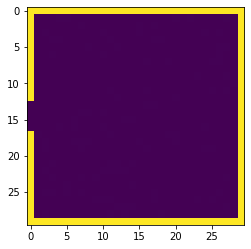

In [18]:
plt.imshow(board)

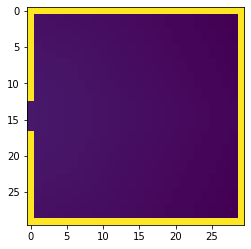

In [19]:
plt.imshow(S)

In [20]:
print(S)

[[500.  500.  500.  500.  500.  500.  500.  500.  500.  500.  500.  500.
  500.  500.  500.  500.  500.  500.  500.  500.  500.  500.  500.  500.
  500.  500.  500.  500.  500.  500. ]
 [500.   21.5  21.   20.5  20.   19.5  19.   18.5  18.   17.5  17.   16.5
   16.   15.   14.   13.   12.   11.   10.    9.    8.    7.    6.    5.
    4.    3.    2.    1.    0.  500. ]
 [500.   22.5  22.   21.5  21.   20.5  20.   19.5  19.   18.5  18.   17.5
   16.5  15.5  14.5  13.5  12.5  11.5  10.5   9.5   8.5   7.5   6.5   5.5
    4.5   3.5   2.5   1.5   0.5 500. ]
 [500.   23.5  23.   22.5  22.   21.5  21.   20.5  20.   19.5  19.   18.
   17.   16.   15.   14.   13.   12.   11.   10.    9.    8.    7.    6.
    5.    4.    3.    2.    1.  500. ]
 [500.   24.5  24.   23.5  23.   22.5  22.   21.5  21.   20.5  19.5  18.5
   17.5  16.5  15.5  14.5  13.5  12.5  11.5  10.5   9.5   8.5   7.5   6.5
    5.5   4.5   3.5   2.5   1.5 500. ]
 [500.   25.5  25.   24.5  24.   23.5  23.   22.5  22.   21.   20.   1

In [21]:
prev_locations = get_locations(person_list)
locations = np.concatenate((prev_locations[0:20, :] + 1, prev_locations[20:, :]))

In [64]:
D = update_D(D, locations, prev_locations, diffusion_factor, decay_factor)

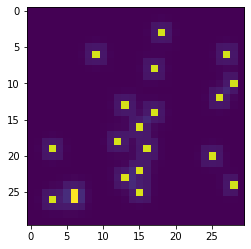

In [65]:
plt.imshow(D)

In [14]:
D.shape

(30, 30)